In [6]:
import os
import sys
import numpy as np
import utilities as utils
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
from collections import Counter
import seaborn as sns

## Model predictions (BERT)

In [7]:
conll03_config = "b1.0-conll03-large"

!ls -l results/{conll03_config}/checkpoint/
!ls -l configs/baselines

total 1303188
-rw-r--r-- 1 dwija dwija       1760 Jun 15 10:17 config.json
-rw-r--r-- 1 dwija dwija 1334453533 Jun 15 10:17 pytorch_model.bin
-rw-r--r-- 1 dwija dwija       1977 Jun 15 10:17 training_meta.bin
total 4
-rw-r--r-- 1 dwija dwija 1884 Jun 15 10:17 b1.0-conll03-large.json


I saved the best predictions of the model in the checkpoint folder (check them out `ls results/b1.0-conll03-large/*.bin`). You can load the predictions along with the lables from those binary files:

In [8]:
!ls results/b1.0-conll03-large/*.bin

results/b1.0-conll03-large/dev_best_preds.bin
results/b1.0-conll03-large/dev_preds_across_epochs.bin
results/b1.0-conll03-large/test_best_preds.bin
results/b1.0-conll03-large/train_preds_across_epochs.bin


In [9]:
import torch
import json
from utilities import EpochStats

conll03_args = utils.load_args(default_config=f"configs/baselines/{conll03_config}.json")

#f" loads a file like object so this one is loading the model's predictions
test_pred_stats = torch.load(f"results/{conll03_config}/test_best_preds.bin")
test_pred_stats.print_classification_report(conll03_args.data.label_scheme)

classes      precision    recall    f1-score    support
---------  -----------  --------  ----------  ---------
LOC             92.679    93.345      93.011       1668
MISC            82.464    81.054      81.753        702
ORG             85.125    91.993      88.426       1661
PER             96.669    95.114      95.885       1617

macro avg       90.330    91.926      91.086       5648
micro avg       90.202    91.926      91.056       5648



Or you can load the predictions, convert them to label (using label_scheme), and then load the actual data (e.g., from the data folder) and align them to check the results. Both ways are equivalent:

In [10]:
from seqeval.metrics import f1_score, precision_score, recall_score
from seqeval.metrics import classification_report

conll03_bert_pred = {
    "ner": test_pred_stats._map_to_labels(conll03_args.data.label_scheme)[1]
}
  
conll03_test = os.path.join(conll03_args.data.directory, "test.txt")
conll03_test = utils.read_conll(conll03_test, columns={'txt': 0, 'ner': 1})

conll03_train = os.path.join(conll03_args.data.directory, "train.txt")
conll03_train = utils.read_conll(conll03_train, columns={'txt': 0, 'ner': 1})


utils.printcr(
    utils.report2dict(
        classification_report(conll03_test['ner'], conll03_bert_pred['ner'], digits=5)
    )
)


classes      precision    recall    f1-score    support
---------  -----------  --------  ----------  ---------
LOC             92.679    93.345      93.011       1668
MISC            82.464    81.054      81.753        702
ORG             85.125    91.993      88.426       1661
PER             96.669    95.114      95.885       1617

macro avg       90.330    91.926      91.086       5648
micro avg       90.202    91.926      91.056       5648



In [11]:
cm_gold=[]
cm_pred=[]
cm_text=[]
cm_train=[]
cm_train_label=[]

for sublist in conll03_test['txt']:
    for item in sublist:
        cm_text.append(item)
        
for sublist in conll03_train['txt']:
    for item in sublist:
        cm_train.append(item)

for sublist in conll03_train['ner']:
    for item in sublist:
        cm_train_label.append(item)

for sublist in conll03_test['ner']:
    for item in sublist:
        cm_gold.append(item)
        
for sublist in conll03_bert_pred['ner']:
    for item in sublist:
        cm_pred.append(item)       

In [12]:
word_counts = Counter(cm_train)
train_list=sorted(word_counts.items(),key=lambda x: x[1])
train_list.reverse()

word_counts = Counter(cm_text)
test_list=sorted(word_counts.items(),key=lambda x: x[1])
test_list.reverse()

dummy_list=[]
for i in test_list:
    dummy_list.append(i[0])

In [13]:
false_pred=[]
false_true=[]
false_text=[]

for i in range(len(cm_gold)): 
    if cm_gold[i]!=cm_pred[i]:
        false_pred.append(cm_pred[i])
        false_true.append(cm_gold[i])
        false_text.append(cm_text[i])   

false_list=[]
word_counts = Counter(false_text)
false_list=sorted(word_counts.items(),key=lambda x: x[1])
false_list.reverse()

dummy_false=[]
for i in false_list:
    dummy_false.append(i[0]) 
 

In [14]:
freq=[]
reappears=[]
for i in train_list:
    if i[0] in false_text:
        freq.append([i[0],i[1]])
        reappears.append(i[0])
for i in freq:
    x=dummy_list.index(i[0])
    i.append(test_list[x][1])

for i in freq:
    x=dummy_false.index(i[0])
    i.append(false_list[x][1])
    

In [15]:
with open("freq.tsv","w+") as file:
    for i in freq:
        file.write(str(i[0])+"\t"+str(i[1])+"\t"+str(i[2])+"\t"+str(i[3])+"\n")

PermissionError: [Errno 13] Permission denied: 'freq.tsv'

In [16]:
mem_freq=[]
for i in range(len(cm_text)):
    if cm_text[i] in reappears:
        #x=cm_text.index(i)
        mem_freq.append(str(cm_text[i])+" "+str(cm_gold[i]))        

In [17]:
token_pred=[]
for i in range(len(cm_text)):
    if cm_text[i] in reappears:
        if cm_pred[i]!= cm_gold[i]:
            token_pred.append(str(cm_text[i])+" "+str(cm_pred[i]))
        

In [18]:
mem_freq_train=[]
for i in range(len(cm_train)):
    if cm_train[i] in reappears:
        mem_freq_train.append(str(cm_train[i])+" "+str(cm_train_label[i]))  

In [19]:
def to_str(ls):
    return " ".join(word for word in ls)

In [20]:
#text, gold, freq in test set gold
tp_counter=Counter(token_pred)
mem_freq_test_counter=Counter(mem_freq)
mem_freq_train_counter=Counter(mem_freq_train)

tp_counter=sorted(tp_counter.items(),key=lambda x: x[0])
tp_counter.reverse()
mem_freq_test_counter=sorted(mem_freq_test_counter.items(),key=lambda x: x[0])
mem_freq_test_counter.reverse()
mem_freq_train_counter=sorted(mem_freq_train_counter.items(),key=lambda x: x[0])
mem_freq_train_counter.reverse()

In [21]:
temp=[]
for i in tp_counter:
    temp.append(i[0])

In [22]:
temp1=[]
for i in mem_freq_test_counter:
    temp1.append(i[0])

In [23]:
mem=[]
for i in mem_freq_train_counter:
    y="NA"
    if i[0] in temp: 
        x=temp.index(i[0])
        y=tp_counter[x][1]
    mem.append([i[0],i[1],y])

for i in mem:
    y="NA"
    if i[0] in temp1:
        x=temp1.index(i[0])
        y=mem_freq_test_counter[x][1]
    i.append(y)
  

In [27]:
targets=["Czech B-MISC"]

In [28]:
sentences=[]
for i in range(len(conll03_test['txt'])):
    for j in range(len(conll03_test['txt'][i])):
        x=str(conll03_test['txt'][i][j])+" "+str(conll03_bert_pred['ner'][i][j])
        y=str(conll03_test['txt'][i][j])+" "+str(conll03_test['ner'][i][j])
        if x != y and x in targets:
            sentences.append([x,to_str(conll03_test['txt'][i])])

In [29]:
sentences

[['Czech B-MISC',
  'Lazio have injury doubts about striker Pierluigi Casiraghi , Czech midfielder Pavel Nedved and defender Paolo Negro , while Roma present a full strength side led by Argentine Abel Balbo , Marco Delvecchio and Francesco Totti in attack .'],
 ['Czech B-MISC',
  "Czech President Vaclav Havel on Friday welcomed the appointment of Madeleine Albright , who is of Czech extraction , as the United States ' first woman Secretary of State ."],
 ['Czech B-MISC',
  "Czech President Vaclav Havel on Friday welcomed the appointment of Madeleine Albright , who is of Czech extraction , as the United States ' first woman Secretary of State ."],
 ['Czech B-MISC',
  "Czech diplomats , seeking to have their country included in the expected expansion of NATO , praised the selection of Albright , known to be a strong supporter of alliance 's integration of former Soveit-bloc countries ."],
 ['Czech B-MISC',
  'Czech ambassador to the United Nations , Karel Kovanda , told the daily Mlada F

In [4]:
#train, pred, gold
with open("mem.tsv","w+") as file:
    for i in mem:
        file.write(str(i[0])+"\t"+str(i[1])+"\t"+str(i[2])+"\t"+str(i[3])+"\n")

PermissionError: [Errno 13] Permission denied: 'mem.tsv'

In [5]:
ds=[]
for i in range(len(conll03_bert_pred["ner"])):
    if conll03_test["ner"][i]!=conll03_bert_pred["ner"][i]:
        for j in range(len(conll03_test["ner"][i])):
            if conll03_test["ner"][i][j]!=conll03_bert_pred["ner"][i][j]:
                ds.append([conll03_test["ner"][i][j],conll03_bert_pred["ner"][i][j],j,conll03_test["txt"][i][j],to_str(conll03_test["txt"][i])])
     

NameError: name 'conll03_bert_pred' is not defined

In [31]:
with open("dsf.tsv","w+") as file:
    for i in ds:
        file.write(str(i[0])+"\t"+str(i[1])+"\t"+str(i[2])+"\t"+str(i[3])+"\t"+str(i[4])+"\n")

In [17]:
cm_classes=sorted(set(cm_gold))
cf_matrix=skm.confusion_matrix(cm_gold,cm_pred,cm_classes)
cf_matrix= pd.DataFrame(cf_matrix)
cf_matrix.columns=cm_classes
cf_matrix.index=cm_classes
cf_matrix

C:\Users\dwija\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,B-LOC,B-MISC,B-ORG,B-PER,I-LOC,I-MISC,I-ORG,I-PER,O
B-LOC,1562,24,59,6,2,1,7,1,6
B-MISC,27,585,49,5,1,5,1,0,29
B-ORG,46,18,1553,12,0,0,9,0,23
B-PER,13,0,40,1543,0,0,1,7,13
I-LOC,0,0,0,0,243,0,9,2,3
I-MISC,1,5,1,0,10,153,24,1,21
I-ORG,2,0,6,0,28,8,767,5,19
I-PER,0,2,0,1,1,0,8,1144,0
O,15,46,77,18,11,46,38,3,38069


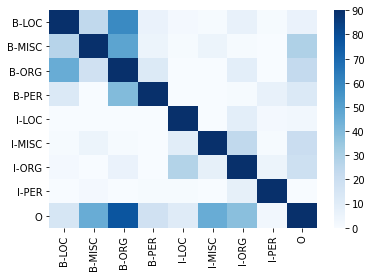

In [18]:
sns.heatmap(cf_matrix, vmin=0, vmax=90, cmap='Blues')

## Load model to predict

In [19]:
import os
import torch
import transformers
from transformers import BertConfig, BertForTokenClassification, BertTokenizer
from nets import NERModel

def load_model(checkpoint_dir, args):
    tokenizer = BertTokenizer.from_pretrained(args.model.pretrained)
    model = NERModel.from_pretrained(checkpoint_dir)
    model.eval()
    labels = args.data.label_scheme
    return model, tokenizer, labels

model, tokenizer, index2label = load_model(f"results/{conll03_config}/checkpoint/", conll03_args)

Define the `predict` function that uses the previously-loaded models:

In [20]:
def predict(tokens, verbose=False):
    # Including special tokens
    input_ids = []
    label_msk = []
    
    for token in tokens:
        bert_tokenized = tokenizer.encode(token, add_special_tokens=False)
        if len(bert_tokenized) == 1:
            input_ids.extend(bert_tokenized)
            label_msk.append(1)
        else:
            input_ids.extend(bert_tokenized)
            label_msk.extend([1] + [0] * (len(bert_tokenized) - 1))
    
    input_ids = torch.tensor([ [tokenizer.cls_token_id] + input_ids ])
    label_msk = torch.tensor([ [0] + label_msk ])
    
    if verbose:
        print(tokens)
        print(tokenizer.tokenize(' '.join(tokens)))
    
    assert input_ids.shape == label_msk.shape
    
    with torch.no_grad():
        losses, scores = model(input_ids, attention_mask=None, token_type_ids=None)
        scores = scores[label_msk == 1]
        logits = torch.softmax(scores, dim=-1)
        classes = torch.argmax(logits, dim=-1).view(-1)
        preds = [index2label[ix] for ix in classes] 
    return preds

## Predict using the model

We can try the fine-tuned modal now:

In [32]:
print(predict("Barack Obama was a president".split()))
print(predict("Gustavo plays at the park".split()))
print(predict("Solorio's speech was inspired".split()))
print(predict("Public Service Minister David Dofara, who is the head of the national Red Cross, told Reuters he had seen the bodies of former interior minister Christophe Grelombe and his son, who was not named .".split()))



['B-PER', 'I-PER', 'O', 'O', 'O']
['B-PER', 'O', 'O', 'O', 'O']
['B-ORG', 'O', 'O', 'O']
['B-ORG', 'I-ORG', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [30]:
def predict_many(sentences):
    predictions = []
    for s in sentences:
        predictions.append(predict(s))
    return predictions
    
predict_many([
    'Barack Obama was a president'.split(),
    'barack obama was a president'.split(),
    'bArAcK oBaMa was a president'.split(),
    'Barack Obama'.split(),
    'barack obama'.split(),
    'bArAcK oBaMa'.split(),
])

[['B-PER', 'I-PER', 'O', 'O', 'O'],
 ['B-PER', 'I-PER', 'O', 'O', 'O'],
 ['B-ORG', 'I-ORG', 'O', 'O', 'O'],
 ['B-PER', 'I-PER'],
 ['O', 'O'],
 ['B-ORG', 'O']]

In [31]:
predict_many([
    'China will be present at the Winter Olympics'.split(),
    'China will be present at the winter olympics'.split(),
    'china will be present at the Winter Olympics'.split(),
    'Russia will be present at the Winter Olympics'.split(),
    'The USA will be present at the Winter Olympics'.split(),
    'the usa will be present at the Winter Olympics'.split(),
    'POLAND GOT MONEY FROM POST-WAR SWISS ACCOUNTS'.split(),
])

[['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC'],
 ['B-ORG', 'O', 'O', 'O', 'O', 'I-LOC', 'O']]

In [13]:
predict_many([
    'I will not go Outside today'.split(),
    'I will not go to the outside today'.split(),
    'I will not go to the Outside today'.split(),
    'I will not go to the Outside Today'.split(),
])

[['O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [14]:
predict_many([
    'Microsoft’s new Edge browser will be built into Windows 10 in the update to be released in August'.split(),
    'julia will be built into Windows 10 again later this year'.split(),
    'Julia will be built into Windows 10 again later this year'.split(),
])

[['B-ORG',
  'O',
  'B-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MISC',
  'I-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O'],
 ['B-PER', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O']]